In [90]:
%load_ext autoreload
%autoreload 2
import sympy as sp
from scipy.optimize import minimize, Bounds
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
dynamics = PlanarQuadrotorDynamicsWithInvertedPendulum(as_numpy=True)

# Planar Quadrotor - Direct Method

In [74]:
def pack_decision_variables(s, u, t_f = None, fixed_final_time = True):
    """Packs decision variables (final time, states, controls) into a 1D vector.
    
    Args:
        t_f: Final time, a scalar.
        s: States, an array of shape (N + 1, s_dim).
        u: Controls, an array of shape (N, u_dim).
    Returns:
        An array `z` of shape (1 + (N + 1) * s_dim + N * u_dim,).
    """
    if fixed_final_time:
        return np.concatenate([s.ravel(), u.ravel()])
    else:
        return np.concatenate([[t_f], s.ravel(), u.ravel()])

def unpack_decision_variables(z, fixed_final_time = True):
    """Unpacks a 1D vector into decision variables (final time, states, controls).
    
    Args:
        z: An array of shape (1 + (N + 1) * s_dim + N * u_dim,).
    Returns:
        t_f: Final time, a scalar.
        s: States, an array of shape (N + 1, s_dim).
        u: Controls, an array of shape (N, u_dim).
    """
    if fixed_final_time:
        s = z[0:(N + 1) * s_dim].reshape(N + 1, s_dim)
        u = z[-N * u_dim:].reshape(N, u_dim)
        return s, u
    else:
        t_f = z[0]
        s = z[1:1 + (N + 1) * s_dim].reshape(N + 1, s_dim)
        u = z[-N * u_dim:].reshape(N, u_dim)
        return t_f, s, u

In [75]:
d2r = np.pi/180
r2d = 180/np.pi

In [76]:
def optimize_trajectory(z0 = None, max_iter=1000, fixed_final_time = True):
    #dynamics = PlanarQuadrotorDynamicsWithInvertedPendulum(as_numpy=True)
    
    circle = False
    sine = False
    
    def cost(z):
        if fixed_final_time:
            s, u = unpack_decision_variables(z, fixed_final_time)
            #if circle:
            #    x_des, y_des = circle_traj(t_f)
            #    x_actual = s[:,0]
            #    y_actual = s[:,1]
            #    return dt*(np.sum(np.square(u))+np.linalg.norm(x_des-x_actual)+np.linalg.norm(y_des-y_actual))
            
            return dt*np.sum(np.square(u))
        else:
            tf, s, u = unpack_decision_variables(z, fixed_final_time)
            
            return tf*0.5 + (tf/N)*np.sum(np.square(u))
            
    
    def constraints(z):
        if fixed_final_time:
            states, controls = unpack_decision_variables(z, fixed_final_time)
        else: 
            tf, states, controls = unpack_decision_variables(z, fixed_final_time)
        constraint_list = [states[0]-s_0, states[-1]-s_f]
        for i in range(N):
            if fixed_final_time:
                constraint_list.append(states[i+1]-(states[i]+(dt)*dynamics(states[i], None, controls[i])))
            else:
                constraint_list.append(states[i+1]-(states[i]+(tf/N)*dynamics(states[i], None, controls[i])))
        return np.concatenate(constraint_list)
    
    if fixed_final_time:
        z_guess = pack_decision_variables(np.linspace(s_0, s_f, N+1), np.ones((N, u_dim)), None, fixed_final_time)
    else:
        z_guess = pack_decision_variables(np.linspace(s_0, s_f, N+1), np.ones((N, u_dim)), 30, fixed_final_time)
        
    if z0 is not None:
        z_guess = z0
        
    z_iterates = [z_guess]

    if fixed_final_time:
        bnds = [(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf)]*(N+1) + [(0,np.inf),(0,np.inf)]*(N)
    else: 
        bnds = [(0, np.inf)] + [(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf)]*(N+1) + [(0,np.inf),(0,np.inf)]*(N)
    
    print("DEBUG: minimizing")
    
    result = minimize(cost,
                      z_guess,
                      method=None,
                      bounds=bnds,
                      constraints={'type':'eq','fun':constraints},
                      options={'maxiter':max_iter},
                      callback=lambda z:z_iterates.append(z))
    
    print("DEBUG: finish minimizing")
    
    print(result)
    
    z_iterates = np.stack(z_iterates)
    z = result.x
    return (unpack_decision_variables(z, fixed_final_time))

# Swing Up Test 1

#### N=20, t_f=5, s_f=[5,8] or [8,10] - successful

In [165]:
N = 20  # Number of time discretization nodes (0, 1, ... N).
s_dim = 8  # State dimension;
u_dim = 2  # Control dimension; 


# For fixed final time ONLY
t_f = 5  
dt = t_f/N

s_0 = np.array([0, 0, 0, 0, 0, 0, 0, 0])  # Initial state.
s_f = np.array([5, 8, 0, np.pi, 0, 0, 0, 0])  # Final state.

In [166]:
s_star, u_star = optimize_trajectory(max_iter=1000, fixed_final_time = True)

DEBUG: minimizing
DEBUG: finish minimizing
     fun: 51920.684286349766
     jac: array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.     

In [167]:
#s, u = optimize_trajectory(z0 = pack_decision_variables(s, u, None, fixed_final_time=True),max_iter=1000, fixed_final_time = True)

In [168]:
t = np.linspace(0, t_f, N + 1)

In [170]:
animate_planar_quad_with_inverted_pendulum(t, s_star[:,0], s_star[:,1], s_star[:,2], s_star[:,3], display_in_notebook=True)

In [ ]:
#ani = animate_planar_quad_with_inverted_pendulum(t, s[:,0], s[:,1], s[:,2], s[:,3], display_in_notebook=False)
#ani = ani.save('planar_quad_with_inverted_pendulum_swing_up_5sec_new_goal_position.mp4', writer='ffmpeg')

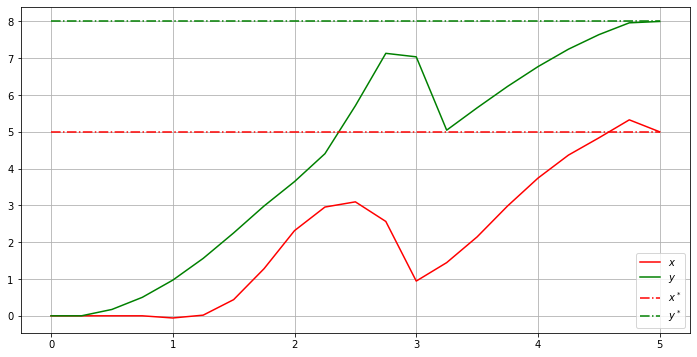

In [175]:
#Now plot the position vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s_star[:, 0],'r',label='$x$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_star[:, 1],'g',label='$y$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[0]*np.ones_like(t),'-.r',label='$x^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[1]*np.ones_like(t),'-.g',label='$y^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

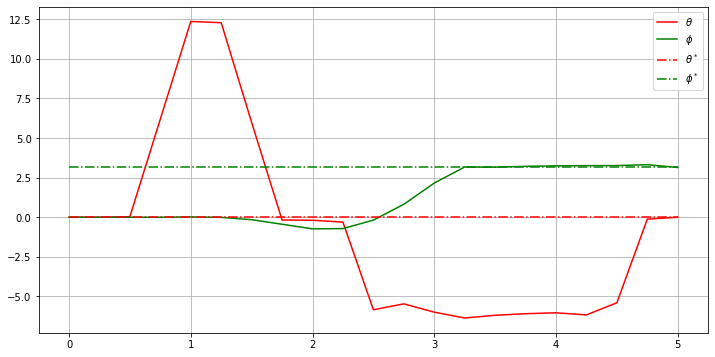

In [174]:
#Now plot the angle vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s_star[:, 2],'r',label='$\\theta$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_star[:, 3],'g',label='$\\phi$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[2]*np.ones_like(t),'-.r',label='$\\theta^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[3]*np.ones_like(t),'-.g',label='$\\phi^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

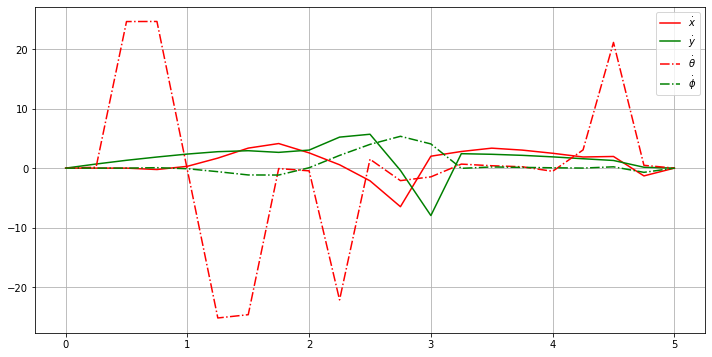

In [176]:
#Now plot the velocity vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s_star[:, 4],'r',label='$\\dot{x}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_star[:, 5],'g',label='$\\dot{y}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_star[:, 6],'-.r',label='$\\dot{\\theta}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_star[:, 7],'-.g',label='$\\dot{\\phi}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

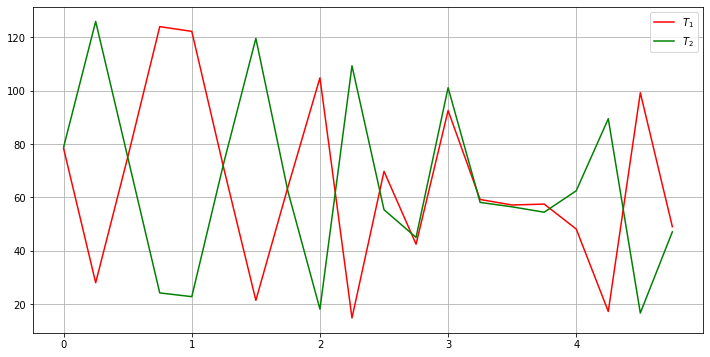

In [177]:
#Now plot the control vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t[:-1],u_star[:, 0],'r',label='$T_1$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t[:-1],u_star[:, 1],'g',label='$T_2$') #Note: when using latex in legends, use double instead of single '\' for variables
#ax.plot(t[:-1],u_star[0]*np.ones_like(t[:-1]),'-.r',label='$T1^*$') #Note: when using latex in legends, use double instead of single '\' for variables
#ax.plot(t[:-1],u_star[0]*np.ones_like(t[:-1]),'-.g',label='$T2^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

# MPC based on direct method trajectory

In [190]:
import cvxpy as cp
from scipy.integrate import odeint
from utils import *
import time

In [195]:
#now make the time series
max_time = 5
freq = 4       # frequency/Hz
dt = 1.0 / freq # useful for the animation function
t = np.linspace(0, max_time, int(freq*max_time))


# s_0 = ([x, y, θ(drone angle), ϕ(pendulum angle), dx, dy, dθ, dϕ]) 
s_0 = s_star[0]  # Initial state.
#s_star = s  # Final state.
u_star = np.ones(dynamics.control_dim) * (dynamics.mp+dynamics.mQ) * dynamics.g/2 # Final control.
#u_star = u

In [196]:
def MPC(A,B,Q,R, state, dynamics, s_star, u_star, horizon = 5):
    state_dim = dynamics.state_dim
    control_dim = dynamics.control_dim
    s = cp.Variable((horizon+1,state_dim))
    u = cp.Variable((horizon,control_dim))
    #T_max = 100
    
    
    constraints = [u >= 0]
    constraints += [s[0] == state]
    obj = cp.quad_form((s[horizon]-s_star),5*Q)
    for i in range(horizon):
        constraints += [s[i+1] == s[i] + A @ (s[i] - s_star) + B @ (u[i] - u_star)]
        #constraints += [cp.norm(u[i],"inf") <= T_max]
        obj += cp.quad_form((s[i] - s_star),Q) + cp.quad_form(u[i] - u_star,R) 

    prob = cp.Problem(cp.Minimize(obj),constraints)
    prob.solve()
    U = u.value
    status = prob.status
    return U[0], prob.status

In [201]:
s2_init_list = [s_0]
noise = False
circle_trj = False
#integrate dynamics output
s2_t_list = []
u_t_list = []
Q = 3 * np.identity(dynamics.state_dim) 
R = np.identity(dynamics.control_dim)
#A = dt * dynamics.dfds(s_star, None, u_star)
#B = dt * dynamics.dfdu(s_star, None, u_star)

for s2_0 in s2_init_list:
    s = np.zeros((t.shape[0], dynamics.state_dim))
    s[0] = s2_0
    u = np.zeros([t.shape[0], dynamics.control_dim])
    for k in range(len(t)-1):
        
        A = dt * dynamics.dfds(s_star[k], None, u_star)
        B = dt * dynamics.dfdu(s_star[k], None, u_star)        
        u[k] = MPC(A,B,Q,R,s[k],dynamics, s_star[k],u_star,horizon = 5)[0]
        #s[k+1] = A@s[k] + B@u[k]
        s[k+1] = odeint(dynamics, s[k], t[k: k+2], (u[k],))[1]
        
    s2_t_list.append(s)
    u_t_list.append(u)

In [202]:
s2_t = s2_t_list[0] 
u_t = u_t_list[0]
animate_planar_quad_with_inverted_pendulum(t, s2_t[:,0], s2_t[:,1], s2_t[:,2], s2_t[:,3], display_in_notebook=True)